In [5]:
!mkdir /data/
!mkdir /data/skincancer/
!wget -P /data/skincancer https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
!unzip -n /data/skincancer/ISIC_2019_Training_Input.zip -d /data/skincancer
#!!ls /data/skincancer/ #ISIC_2019_Training_Input/

#https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip

Streaming output truncated to the last 5000 lines.
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: /data/skincancer/ISIC_2019_Training_Input/ISIC_0

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [8]:
!wget -P /data/skincancer/ https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv

--2021-02-07 00:41:42--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.26.220
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.26.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214351 (1.2M) [text/csv]
Saving to: ‘/data/skincancer/ISIC_2019_Training_Metadata.csv’

ISIC_2019_Training_ 100%[===================>]   1.16M  6.45MB/s    in 0.2s    

2021-02-07 00:41:43 (6.45 MB/s) - ‘/data/skincancer/ISIC_2019_Training_Metadata.csv’ saved [1214351/1214351]



In [9]:
#import os 
#from glob import glob
#import pandas as pd 

base_skin_dir = os.path.join('..', 'data/skincancer/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'ISIC_2019_Training_Metadata.csv'))

print(skin_df.head(20))
# Creating New Columns for better readability

skin_df['path'] = skin_df['image'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['lesion_id'].map(lesion_type_dict.get) 
#skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

print(skin_df.head(20))

                       image  age_approx anatom_site_general lesion_id     sex
0               ISIC_0000000        55.0      anterior torso       NaN  female
1               ISIC_0000001        30.0      anterior torso       NaN  female
2               ISIC_0000002        60.0     upper extremity       NaN  female
3               ISIC_0000003        30.0     upper extremity       NaN    male
4               ISIC_0000004        80.0     posterior torso       NaN    male
5               ISIC_0000006        25.0     posterior torso       NaN  female
6               ISIC_0000007        25.0     posterior torso       NaN  female
7               ISIC_0000008        30.0      anterior torso       NaN  female
8               ISIC_0000009        30.0      anterior torso       NaN  female
9               ISIC_0000010        35.0     posterior torso       NaN  female
10              ISIC_0000011        35.0     lower extremity       NaN  female
11              ISIC_0000012        30.0     posteri

In [10]:
!wget -P /data/skincancer/ https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv

skingt_df = pd.read_csv(os.path.join(base_skin_dir, 'ISIC_2019_Training_GroundTruth.csv'))

print(skingt_df.head(20))
print(skingt_df.columns.values)

skin_df = skin_df.merge(skingt_df)
print(skin_df.head())

--2021-02-07 00:42:25--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.92.20
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.92.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1291479 (1.2M) [text/csv]
Saving to: ‘/data/skincancer/ISIC_2019_Training_GroundTruth.csv’

ISIC_2019_Training_ 100%[===================>]   1.23M  6.92MB/s    in 0.2s    

2021-02-07 00:42:25 (6.92 MB/s) - ‘/data/skincancer/ISIC_2019_Training_GroundTruth.csv’ saved [1291479/1291479]

                       image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0               ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1               ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2               ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3               ISIC_0000

In [11]:
#print(skin_df.isnull().sum())
target = skin_df[['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']].values
print(target.dtype,target.shape)

float64 (25331, 9)


In [12]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

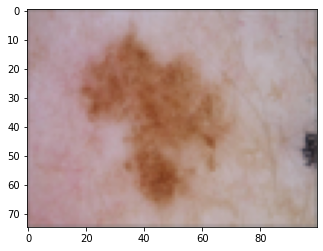

In [14]:
n_samples = 5
#fig, m_axs = plt.subplots(n_samples,1, figsize = (4*n_samples, 3*7))
#print(m_axs)
#for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
#    n_axs[0].set_title(type_name)
#    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
#        c_ax.imshow(c_row['image'])
#        c_ax.axis('off')
#for ax,im in zip:

plt.imshow(skin_df['image'][20])

In [15]:
features = skin_df['image']# .values
x_train_o, x_test_o, y_train, y_test = train_test_split(features, target, test_size=0.40,random_state=1234)

x_train = np.asarray(x_train_o.tolist()) # ['image'].tolist())
x_test = np.asarray(x_test_o.tolist()) # ['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

print(x_train.shape)

(15198, 75, 100, 3)


In [16]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)


x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [17]:
# based on https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py
from tensorflow.keras.layers import Dense, Conv2D,Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    d = Dense(64,activation='relu')(y)
    d = Dropout(0.3)(d)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(d) # y
    
    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
# Set the CNN model 
input_shape = (75, 100, 3)
num_classes = 9

n = 7 #3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 2

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
    model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)
elif version == 2:
    depth = n * 9 + 2
    model = resnet_v2(input_shape=input_shape, depth=depth,num_classes=num_classes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 100, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 100, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 100, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 75, 100, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 30:
        lr = 0.5e-6
    elif epoch > 20:
        lr = 1e-5
    elif epoch > 10:
        lr = 0.5e-4
    print('Learning rate: ', lr)
    return lr

In [21]:

optimizer = Adam(lr=lr_schedule(0)) # 1e-4)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

Learning rate:  0.001


In [22]:


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [23]:

epochs = 40
batch_size = 10

lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[lr_scheduler])
#history = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_validate,y_validate),batch_size=batch_size,callbacks=[learning_rate_reduction])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
Learning rate:  0.001
1367/1367 [==============================] - 101s 63ms/step - loss: 2.4257 - accuracy: 0.4791 - val_loss: 1.5108 - val_accuracy: 0.5487
Epoch 2/40
Learning rate:  0.001
1367/1367 [==============================] - 85s 62ms/step - loss: 1.5336 - accuracy: 0.5431 - val_loss: 1.3186 - val_accuracy: 0.5724
Epoch 3/40
Learning rate:  0.001
1367/1367 [==============================] - 85s 62ms/step - loss: 1.3560 - accuracy: 0.5579 - val_loss: 1.2765 - val_accuracy: 0.5836
Epoch 4/40
Learning rate:  0.001
1367/1367 [==============================] - 85s 62ms/step - loss: 1.3195 - accuracy: 0.5580 - val_loss: 1.3519 - val_accuracy: 0.5605
Epoch 5/40
Learning rate:  0.001
1367/1367 [==============================] - 85s 62ms/step - loss: 1.2924 - accuracy: 0.5685 - val_loss: 1.2171 - val_accuracy: 0.5888
Epoch 6/40
Learning rate:  0.001
1367/1367 [==============================] - 85s 62ms/step - loss: 1.2507 - accuracy: 0.5753 - val_loss: 1.1891 - val_accuracy

In [24]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#model.save("model.h5")

1520/1520 [==============================] - 1s 856us/sample - loss: 1.0663 - acc: 0.6480
Validation: accuracy = 0.648026  ;  loss_v = 1.066276
Test: accuracy = 0.648475  ;  loss = 1.045246


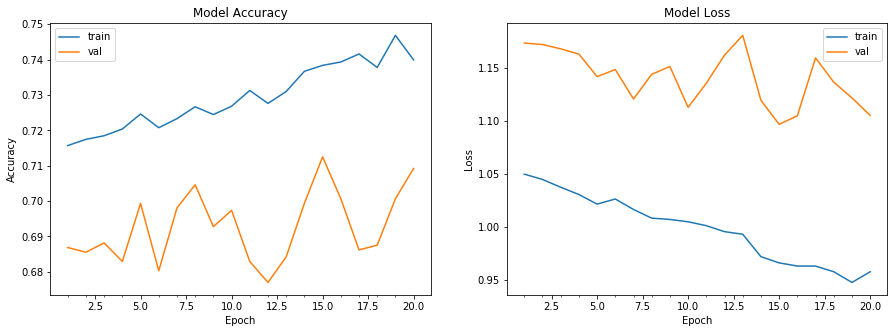

In [ ]:
plot_model_history(history)